In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# 讀入資料

In [2]:
# 用來fit的資料
data = pd.read_excel(
    '/Users/andy/Desktop/RA project for professor Yueh/2020:3 - 2020:6/data/Project_data_20200131_with My Marking.xlsx',
    'C_Price_OIS '
)
    
data_dict = {}
for key in data['Trade ID'].index:
    main_key = data['Trade ID'][key][:3]
    if main_key not in data_dict.keys():
        data_dict[main_key] = {}
    data_dict[main_key][key] = {}
    data_dict[main_key][key]['name'] = data['Trade ID'][key]
    data_dict[main_key][key]['target_price'] = data['AnalyticPrice'][key]
    data_dict[main_key][key]['K'] = data['Fixed Rate'][key]
    
# 讀入估好NSS的參數
NSS_model_parameters = pd.read_csv('NSS_model_parameters.csv')

# 建立NSS function
# Nelson-Siegel-Svensson Approach
def function_NSS(t, B_0, B_1, B_2, B_3, theta_NSS, vega):
    return (
        B_0 +
        B_1 * ((1 - np.exp(-t/theta_NSS)) / (t/theta_NSS)) +
        B_2 * (((1 - np.exp(-t/theta_NSS)) / (t/theta_NSS)) - np.exp(-t/theta_NSS)) +
        B_3 * (((1 - np.exp(-t/vega)) / (t/vega)) - np.exp(-t/vega))
    )

# 帶入對應Ｔ就可以得到對應值
# function_NSS(1, *NSS_model_parameters.values[0])

# 預設參數

In [3]:
k = 0.03
notional_amount = 1000000

# swap的交換利率的頻率
delta=0.5

# 建立一些從swaption名稱萃取資訊的function

In [4]:
def extract_option_maturity(swaption_name):
    # 萃取出前段數值與後段對應的月份或年份
    # 格式例子：'01m01y', '01y01y'
    # 前段
    front_num = int(swaption_name[:2])
    
    # 後段
    if swaption_name[2] == 'm':
        back_time = 1/12
    elif swaption_name[2] == 'y':
        back_time = 1
        
    # 轉換成年為單位
    return float(front_num * back_time)

def extract_swap_maturity(swaption_name):
    # 萃取出swap的maturity
    # 格式例子：'01m01y'
    return float(swaption_name[3:-1])

# 把需要的時間資訊萃取出來
for main_key in data_dict.keys():
    for sub_key in data_dict[main_key]:
        name = data_dict[main_key][sub_key]['name']
        t_T = extract_option_maturity(name)
        Tn = extract_swap_maturity(name)
        
        data_dict[main_key][sub_key]['t_T'] = t_T
        data_dict[main_key][sub_key]['Tn'] = Tn

# 建立target function中的sub function

In [5]:
def P(Time):
    return np.exp(-function_NSS(Time, *NSS_model_parameters.values[0]) * Time)

def B_T_Tn(T_Tn):
    return (1/k) * (
        1 - np.exp(-k*(T_Tn))
    )

def VP_T_Tn(sigma_r_square, t_T, T_Tn):
    return (
        (B_T_Tn(T_Tn)**2) *
        (sigma_r_square/(2*k)) *
        (1 - np.exp(-2*k*t_T))
    )**0.5

# target function中最後會被call的主要function
def inner_target_function(parameters_collection, sigma_r_square):
    t_T, T_Tn, t_Tn, K = parameters_collection
    return (
        (1 + K*delta) * (
            (1/(1 + K*delta)) *
            P(t_T) *
            norm.cdf(
                -np.log(P(t_Tn)/(K*P(t_T))) / VP_T_Tn(sigma_r_square, t_T, T_Tn) +
                0.5*VP_T_Tn(sigma_r_square, t_T, T_Tn)
            ) - 
            P(t_Tn) *
            norm.cdf(
                -np.log(P(t_Tn)/(K*P(t_T))) / VP_T_Tn(sigma_r_square, t_T, T_Tn) -
                0.5*VP_T_Tn(sigma_r_square, t_T, T_Tn)
            )
        )
    )

# 建立target function(最外層吃t_T, Tn, K )

In [6]:
# 透過兩層print可以檢視當前帶入參數值與對應結果，用來debug
def target_function(intital_parameters_collection, sigma_r_square):
    # 把當前帶入的參數print出來
    print('intital_parameters_collection:\n{}'.format(
        intital_parameters_collection
    ))
    t_T, Tn, K = intital_parameters_collection
    
    series_of_inner_target_function = np.array(list(map(
        lambda T_Tn: inner_target_function(
            [t_T, T_Tn, t_T+T_Tn, K], sigma_r_square
        ),
        np.arange(delta, Tn+delta, delta)
    ))) * notional_amount
    
    summation_of_inner_target_function = sum(series_of_inner_target_function)
    
    # 把fit過程當前結果print出來
    print('series_of_inner_target_function:\n{}'.format(
        series_of_inner_target_function
    ))
    print('summation_of_inner_target_function:\n{}'.format(
        summation_of_inner_target_function
    ))
    print('current_sigma_r_square:\n{}'.format(
        sigma_r_square
    ))
    print('')
    
    return summation_of_inner_target_function

# 建立最外層target_function

In [7]:
# 由於curve_fit是透過array直接送進去，因此要再包一層把array拆成一組組參數才送進function
# 解法來源：https://stackoverflow.com/questions/34136737/using-scipy-curve-fit-for-a-variable-number-of-parameters
def wrapper_target_function(x_data, sigma_r_square):
    return list(map(
        lambda intital_parameters_collection: target_function(
            intital_parameters_collection, sigma_r_square
        ),
        np.stack(x_data, axis=1)
    ))

# 估計swaption中相同option maturity的sigma_r_square

In [8]:
result = pd.DataFrame([])

for current_swaption_name in list(data_dict.keys()):
    print('Fitting... {}'.format(current_swaption_name))
    print('')
    
    # 指定欲估計的合約資料
    target_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['target_price'],
        data_dict[current_swaption_name].keys()
    ))

    t_T_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['t_T'],
        data_dict[current_swaption_name].keys()
    ))

    Tn_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['Tn'],
        data_dict[current_swaption_name].keys()
    ))

    K_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['K'],
        data_dict[current_swaption_name].keys()
    ))
    
    # 估計參數
    # 估計過程會一直call內層的target_function，因此會一直有東西print出來
    # 此時就可以看print出來的值是否為當前應該被估計的參數組
    # 估計完成後print才會暫停
    popt, pcov = curve_fit(
        wrapper_target_function,
        (t_T_series, Tn_series, K_series),
        target_series,
        maxfev=500000
    )
    print('--------------------------------------------------------------------------------')
    print('fitting finished')
    print('')
    print('estimated sigma_r_square: {}'.format(popt[0]))
    
    # 計算MSE
    # 最後由於要在記錄一次predict_data因此會在call到內層的target_function
    # 此時虛線內print出來的值，與虛線外的最後一個print出來的值會是相同的
    # 因為估計值在最後一個print出來的地方暫停了
    predict_series = wrapper_target_function((t_T_series, Tn_series, K_series), *popt)
    MSE = round(sum(
        map(lambda x: x**2, np.array(predict_series) - np.array(target_series))
    ) / len(target_series), 2)

    print('MSE: {}'.format(MSE))
    print('--------------------------------------------------------------------------------')
    print('')
    
    temp_result = pd.DataFrame([[
        current_swaption_name, popt[0], MSE
    ]], columns=[
        'swaption_name', 'popt', 'MSE'
    ])
    
    result = pd.concat([result, temp_result])
    
result.reset_index(drop=True, inplace=True)

Fitting... 01m

intital_parameters_collection:
[0.08333333 1.         0.01364652]
series_of_inner_target_function:
[1.37134216e-190 1.06614738e-044]
summation_of_inner_target_function:
1.0661473836522789e-44
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.08333333 2.         0.01231497]
series_of_inner_target_function:
[5.03010416e-200 4.42867474e-047 1.81169243e-018 2.46403951e-008]
summation_of_inner_target_function:
2.4640395145966552e-08
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.08333333 3.         0.01184772]
series_of_inner_target_function:
[1.22669438e-203 5.42433472e-048 7.07675364e-019 1.44837765e-008
 9.93479979e-004 4.59748507e-001]
summation_of_inner_target_function:
0.46074200146192723
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.08333333 4.         0.01170424]
series_of_inner_target_function:
[8.79337123e-205 2.78891062e-048 5.25401804e-019 1.22396291e-008
 8.91754791e-004 4.26512520e-001 1.86436829e+001 2.25033260e+00

 5.96023041e+002 2.39689990e+003]
summation_of_inner_target_function:
3086.330970817494
current_sigma_r_square:
0.8997437469120909

MSE: 1690901.22
--------------------------------------------------------------------------------

Fitting... 03m

intital_parameters_collection:
[0.25      1.        0.0128987]
series_of_inner_target_function:
[1.79201906e-62 4.15169796e-12]
summation_of_inner_target_function:
4.151697960673527e-12
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.25       2.         0.01191142]
series_of_inner_target_function:
[6.06279417e-65 9.98640616e-13 6.92172110e-03 2.28466685e+01]
summation_of_inner_target_function:
22.853590235387212
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.25       3.         0.01159588]
series_of_inner_target_function:
[8.70060946e-66 6.14074385e-13 5.58293971e-03 2.02757827e+01
 9.85905647e+02 8.55729782e+03]
summation_of_inner_target_function:
9563.484829824869
current_sigma_r_square:
1.0

intital_parameters_

series_of_inner_target_function:
[7.92154626e-181 3.31537544e-042 2.93393369e-016 4.60436779e-007
 9.54660773e-003 2.29543486e+000]
summation_of_inner_target_function:
2.304981930570828
current_sigma_r_square:
0.37994401320095583

intital_parameters_collection:
[0.25       4.         0.01154375]
series_of_inner_target_function:
[3.34321054e-181 2.66690404e-042 2.66174683e-016 4.35808730e-007
 9.21621922e-003 2.24005378e+000 6.48793821e+001 5.97989188e+002]
summation_of_inner_target_function:
665.1178402375983
current_sigma_r_square:
0.37994401320095583

intital_parameters_collection:
[0.25       5.         0.01166243]
series_of_inner_target_function:
[2.36632692e-180 4.36962562e-042 3.31962837e-016 4.93691336e-007
 9.98281584e-003 2.36766195e+000 6.75636374e+001 6.16716366e+002
 2.88081088e+003 8.83449195e+003]
summation_of_inner_target_function:
12401.960473936128
current_sigma_r_square:
0.37994401320095583

intital_parameters_collection:
[0.25      1.        0.0128987]
series_of_inne

 3.61507685e+04 1.12926407e+05]
summation_of_inner_target_function:
153821.5587890943
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.5        4.         0.01135463]
series_of_inner_target_function:
[4.57311917e-31 4.78732426e-04 6.60294180e+01 4.73798686e+03
 3.64222766e+04 1.13474786e+05 2.27626108e+05 3.58065308e+05]
summation_of_inner_target_function:
740392.4962861679
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.5     5.      0.01156]
series_of_inner_target_function:
[8.79760877e-31 5.62936461e-04 7.08360478e+01 4.92146545e+03
 3.72705119e+04 1.15178655e+05 2.29924455e+05 3.60559764e+05
 4.88850644e+05 6.03687855e+05]
summation_of_inner_target_function:
1840464.1883608857
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.5        1.         0.01198857]
series_of_inner_target_function:
[3.29524111e-30 7.80684407e-04]
summation_of_inner_target_function:
0.000780684406519912
current_sigma_r_square:
1.0

intital_parameters_collection:
[0.5

 2.24608058e+003 7.19045475e+003]
summation_of_inner_target_function:
9936.562007134533
current_sigma_r_square:
0.1847647457565303

intital_parameters_collection:
[0.5        1.         0.01198857]
series_of_inner_target_function:
[3.16369213e-192 4.10463206e-045]
summation_of_inner_target_function:
4.1046320560447527e-45
current_sigma_r_square:
0.177681282094033

intital_parameters_collection:
[0.5        2.         0.01141146]
series_of_inner_target_function:
[1.23281596e-196 3.16488135e-046 4.45294015e-018 4.17685965e-008]
summation_of_inner_target_function:
4.1768596468874603e-08
current_sigma_r_square:
0.177681282094033

intital_parameters_collection:
[0.5        3.         0.01128885]
series_of_inner_target_function:
[1.31491295e-197 1.79894198e-046 3.45810624e-018 3.62079803e-008
 1.81917924e-003 7.10071452e-001]
summation_of_inner_target_function:
0.7118906677226187
current_sigma_r_square:
0.177681282094033

intital_parameters_collection:
[0.5        4.         0.01135463]
seri


intital_parameters_collection:
[1.        5.        0.0115702]
series_of_inner_target_function:
[3.73834086e-13 2.03500013e+01 9.12935022e+03 8.45313346e+04
 2.43248990e+05 4.31722649e+05 6.02693080e+05 7.36330472e+05
 8.31236540e+05 8.94087975e+05]
summation_of_inner_target_function:
3833000.7402905365
current_sigma_r_square:
1.0

intital_parameters_collection:
[1.        1.        0.0110028]
series_of_inner_target_function:
[1.47836453e-13 1.62565032e+01]
summation_of_inner_target_function:
16.256503207469017
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[1.         2.         0.01093781]
series_of_inner_target_function:
[1.32436821e-13 1.58292525e+01 8.22051816e+03 8.01140594e+04]
summation_of_inner_target_function:
88350.40686133115
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[1.         3.         0.01102833]
series_of_inner_target_function:
[1.54328938e-13 1.64265521e+01 8.34862040e+03 8.07507774e+04
 2.37060326e+05 4.2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  



summation_of_inner_target_function:
561.8677093046012
current_sigma_r_square:
0.09625435205248653

intital_parameters_collection:
[1.        5.        0.0115702]
series_of_inner_target_function:
[7.82455698e-183 9.87960668e-043 1.68297867e-016 3.34024523e-007
 7.73365009e-003 1.97545735e+000 5.89626827e+001 5.54168979e+002
 2.64105361e+003 8.21617536e+003]
summation_of_inner_target_function:
11472.343824749649
current_sigma_r_square:
0.09625435205248653

intital_parameters_collection:
[1.        1.        0.0110028]
series_of_inner_target_function:
[4.4556557e-187 8.3868462e-044]
summation_of_inner_target_function:
8.386846196431825e-44
current_sigma_r_square:
0.09625435348678815

intital_parameters_collection:
[1.         2.         0.01093781]
series_of_inner_target_function:
[1.39842874e-187 6.26025957e-044 4.89833508e-017 1.66377876e-007]
summation_of_inner_target_function:
1.663778761420514e-07
current_sigma_r_square:
0.09625435348678815

intital_parameters_collection:
[1.       

 6.03693862e+05 7.78792581e+05]
summation_of_inner_target_function:
1852553.9304533554
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[2.         4.         0.01171605]
series_of_inner_target_function:
[3.12028732e-04 4.45770014e+03 1.12794800e+05 3.60913801e+05
 6.07455811e+05 7.81113191e+05 8.82554929e+05 9.34630144e+05]
summation_of_inner_target_function:
3683920.3755903887
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[2.         5.         0.01203771]
series_of_inner_target_function:
[4.00933460e-04 4.72403848e+03 1.15351250e+05 3.64621554e+05
 6.10445706e+05 7.82950815e+05 8.83512730e+05 9.35072938e+05
 9.58919912e+05 9.69003831e+05]
summation_of_inner_target_function:
5624602.775334269
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[2.         1.         0.01087209]
series_of_inner_target_function:
[nan nan]
summation_of_inner_target_function:
nan
current_sigma_r_square:
-0.6987094595289036

int

 5.76859162e+003 1.56290971e+004]
summation_of_inner_target_function:
23078.1780666169
current_sigma_r_square:
0.055822309177364936

intital_parameters_collection:
[2.         1.         0.01087209]
series_of_inner_target_function:
[1.51742258e-166 1.37718006e-038]
summation_of_inner_target_function:
1.3771800632415533e-38
current_sigma_r_square:
0.05582231000918216

intital_parameters_collection:
[2.        2.        0.0110413]
series_of_inner_target_function:
[2.21949200e-165 2.70934151e-038 1.73651302e-014 4.82009056e-006]
summation_of_inner_target_function:
4.820090581742085e-06
current_sigma_r_square:
0.05582231000918216

intital_parameters_collection:
[2.         3.         0.01132478]
series_of_inner_target_function:
[1.77862172e-163 8.18540491e-038 2.84638619e-014 6.36915950e-006
 5.32783841e-002 7.78987781e+000]
summation_of_inner_target_function:
7.843162565524932
current_sigma_r_square:
0.05582231000918216

intital_parameters_collection:
[2.         4.         0.01171605]
se

series_of_inner_target_function:
[2.08397470e+02 1.48153132e+05 5.31430865e+05 7.89808940e+05
 8.97612054e+05 9.31422568e+05 9.39842535e+05 9.41546735e+05
 9.41831082e+05 9.41870624e+05 9.41875251e+05 9.41875710e+05
 9.41875749e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
44738756.47879242
current_sigma_r_square:
1.0

intital_parameters_collection:
[5.00000000e+00 3.00000000e+01 1.52600843e-02]
series_of_inner_target_function:
[1.911666

 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
16477085.515805554
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[ 5.         15.          0.01575126]
series_of_inner_target_function:
[2.14539438e+02 1.49030470e+05 5.32387740e+05 7.90256250e+05
 8.97756189e+05 9.31458476e+05 9.39849743e+05 9.41547925e+05
 9.41831246e+05 9.41870643e+05 9.41875253e+05 9.41875710e+05
 9.41875749e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
25903717.72394207
current_sigma_r_square:
1.0000000149011612

intital_parameters_collection:
[5.00000000e+00 2.00000000e+01 1.57420737e-02]
series_of_inner_target_function:
[2.14086191e+02 1.48966420e+05 5.32318024e+05 7.90223684e+05
 8.97745

 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
53430251.003207274
current_sigma_r_square:
0.6442150596170892

intital_parameters_collection:
[ 5.         10.          0.01535531]
series_of_inner_target_function:
[1.75917129e+00 4.05993852e+04 2.97275122e+05 5.93805879e+05
 7.86320696e+05 8.81915551e+05 9.21572422e+05 9.35775187e+05
 9.40237847e+05 9.41480580e+05 9.41789638e+05 9.41858721e+05
 9.41872681e+05 9.41875245e+05 9.41875675e+05 9.41875742e+05
 9.41875751e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
15757635.138098909
current_sigma_r_square:
0.6442150692166417

intital_parameters_collection:
[ 5.         15.          0.01575126]
series_of_inner_target_function:
[2.03878335e+00 4.19416414e+04 3.00720884e+05 5.96548393e+05
 7.87768521e+05 8.82524157e+05 9.21789259e+05 9.35842488e+05
 9.40256317e+05 9.41485106e+05 9.41790635e+05 9.41858920e+05
 9.41872717e+05 9.41875251e+05 9.41875676e+05 9

 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05]
summation_of_inner_target_function:
33433372.504590735
current_sigma_r_square:
0.3705930047455824

intital_parameters_collection:
[5.00000000e+00 2.50000000e+01 1.56257361e-02]
series_of_inner_target_function:
[1.39060111e-04 3.20314171e+03 9.00854411e+04 3.04327401e+05
 5.32803771e+05 7.06855318e+05 8.18093652e+05 8.81358551e+05
 9.14208352e+05 9.29988289e+05 9.37057415e+05 9.40027398e+05
 9.41202777e+05 9.41642571e+05 9.41798668e+05 9.41851382e+05
 9.41868366e+05 9.41873602e+05 9.41875149e+05 9.41875589e+05
 9.41875710e+05 9.41875742e+05 9.41875750e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e+05
 9.41875752e+05 9.41875752e+05 9.41875752e+05 9.41875752e

[ 5.         10.          0.01535531]
series_of_inner_target_function:
[6.08563520e-67 2.74970318e-13 3.54009507e-03 1.45417036e+01
 7.49684147e+02 6.72917376e+03 2.60924678e+04 6.41183413e+04
 1.20160946e+05 1.89560766e+05 2.66459947e+05 3.45560230e+05
 4.22807169e+05 4.95455815e+05 5.61875016e+05 6.21283578e+05
 6.73502890e+05 7.18754416e+05 7.57505487e+05 7.90357411e+05]
summation_of_inner_target_function:
6060987.884482059
current_sigma_r_square:
0.04968307426909167

intital_parameters_collection:
[ 5.         15.          0.01575126]
series_of_inner_target_function:
[4.47555820e-66 4.53490096e-13 4.41801687e-03 1.64507177e+01
 8.10212553e+02 7.09332245e+03 2.70925033e+04 6.59257528e+04
 1.22720113e+05 1.92671688e+05 2.69879083e+05 3.49065152e+05
 4.26224438e+05 4.98665782e+05 5.64805475e+05 6.23899616e+05
 6.75796615e+05 7.20736139e+05 7.59196777e+05 7.91785954e+05
 8.19163454e+05 8.41990480e+05 8.60897463e+05 8.76465308e+05
 8.89216024e+05 8.99609686e+05 9.08045546e+05 9.14865667

 2.62164340e+003 3.14556046e+003]
summation_of_inner_target_function:
15584.32657313304
current_sigma_r_square:
0.000985436232288828

intital_parameters_collection:
[5.00000000e+00 3.00000000e+01 1.52600843e-02]
series_of_inner_target_function:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.68622760e-229
 5.70693604e-147 7.45480689e-102 1.77671622e-074 1.35604136e-056
 2.96035686e-044 2.26091606e-035 9.31345122e-029 1.07843140e-023
 9.97872580e-020 1.46766267e-016 5.47829953e-014 7.20007481e-012
 4.21377178e-010 1.30418738e-008 2.42710277e-007 2.99374505e-006
 2.63813208e-005 1.76099703e-004 9.32578409e-004 4.06552318e-003
 1.50310720e-002 4.82878571e-002 1.37501094e-001 3.52815130e-001
 8.27029421e-001 1.79154071e+000 3.62146172e+000 6.88770750e+000
 1.24124211e+001 2.13231909e+001 3.51012533e+001 5.56192728e+001
 8.51652304e+001 1.26450212e+002 1.82599286e+002 2.57125952e+002
 3.53891788e+002 4.77053690e+002 6.31001657e+002 8.20290258e+002
 1.04956688e+003 1.32349965e+003 1.64670

series_of_inner_target_function:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 3.30827390e-212
 9.05674651e-136 5.54586209e-094 1.26477242e-068 4.64005677e-052
 1.24927598e-040 2.11699975e-032 2.84450303e-026 1.39814476e-021
 6.61619935e-018 5.69902152e-015 1.37826449e-012 1.26741085e-010
 5.50813396e-009 1.32671615e-007 1.99467684e-006 2.04865960e-005
 1.54079949e-004 8.95888681e-004 4.20338336e-003 1.64679699e-002
 5.53813263e-002 1.63503206e-001 4.31657182e-001 1.03473326e+000
 2.28095485e+000 4.67343299e+000 8.98041252e+000 1.63086060e+001
 2.81728623e+001 4.65553283e+001 7.39481630e+001 1.13375502e+002
 1.68392399e+002 2.43060531e+002 3.41902313e+002 4.69836481e+002]
summation_of_inner_target_function:
1519.1940057126824
current_sigma_r_square:
0.00104825509946406

intital_parameters_collection:
[5.00000000e+00 2.50000000e+01 1.56257361e-02]
series_of_inner_target_function:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 5.51024593e-213
 2.83485472e-136 2.45097215e-094 6.89126

series_of_inner_target_function:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.03273525e-213
 9.58484038e-137 1.14391012e-094 3.91068690e-069 1.86882582e-052
 6.03790961e-041 1.16660808e-032 1.72828328e-026 9.15379493e-022
 4.59251198e-018 4.14482462e-015 1.04106959e-012 9.87635783e-011
 4.40516404e-009 1.08452507e-007 1.66120009e-006 1.73365427e-005
 1.32204652e-004 7.78019412e-004 3.68916351e-003 1.45888533e-002
 4.94697030e-002 1.47132052e-001 3.91012557e-001 9.42892850e-001
 2.08969305e+000 4.30244574e+000 8.30420299e+000 1.51416234e+001
 2.62537717e+001 4.35314604e+001 6.93612282e+001 1.06649565e+002
 1.58824919e+002 2.29817019e+002 3.24014893e+002 4.46206370e+002
 6.01502864e+002 7.95253759e+002 1.03295479e+003 1.32015464e+003
 1.66236338e+003 2.06496598e+003 2.53314314e+003 3.07180133e+003
 3.68551299e+003 4.37846752e+003]
summation_of_inner_target_function:
22582.16731231931
current_sigma_r_square:
0.001044761114416673

intital_parameters_collection:
[5.00000000e+00 3.0000

summation_of_inner_target_function:
8.330611645640959
current_sigma_r_square:
0.0010447554433172682

intital_parameters_collection:
[5.00000000e+00 2.00000000e+01 1.57420737e-02]
series_of_inner_target_function:
[0.00000000e+000 0.00000000e+000 0.00000000e+000 6.22079267e-213
 3.06868303e-136 2.59223575e-094 7.18541789e-069 2.99413518e-052
 8.80114798e-041 1.58865693e-032 2.23728798e-026 1.13991739e-021
 5.54805722e-018 4.88735868e-015 1.20367084e-012 1.12355352e-010
 4.94421689e-009 1.20346730e-007 1.82562291e-006 1.88947155e-005
 1.43053718e-004 8.36601304e-004 3.94517223e-003 1.55256587e-002
 5.24199700e-002 1.55308796e-001 4.11324605e-001 9.88807305e-001
 2.18533208e+000 4.48796647e+000 8.64233348e+000 1.57250505e+001
 2.72129346e+001 4.50422176e+001 7.16518541e+001 1.10006576e+002
 1.63597330e+002 2.36418765e+002 3.32925279e+002 4.57968551e+002]
summation_of_inner_target_function:
1477.4925228999612
current_sigma_r_square:
0.0010447554433172682

intital_parameters_collection:
[5.0

 876012.42751943 876012.42751943 876012.42751943 876012.42751943]
summation_of_inner_target_function:
15843973.472341098
current_sigma_r_square:
0.8689450597851384

intital_parameters_collection:
[10.         15.          0.01631158]
series_of_inner_target_function:
[  3987.91721599 310200.21114208 684825.03111365 832971.01297184
 869066.35551298 875188.47765243 875939.51111301 876007.55289984
 876012.17839161 876012.4176711  876012.42721479 876012.42751198
 876012.42751929 876012.42751943 876012.42751943 876012.42751943
 876012.42751943 876012.42751943 876012.42751943 876012.42751943
 876012.42751943 876012.42751943 876012.42751943 876012.42751943
 876012.42751943 876012.42751943 876012.42751943 876012.42751943
 876012.42751943 876012.42751943]
summation_of_inner_target_function:
24600459.215760976
current_sigma_r_square:
0.8689450597851384

intital_parameters_collection:
[10.         10.          0.01657736]
series_of_inner_target_function:
[  4137.9001891  312263.03293393 685913.288

 3.36978971e+005 3.86105318e+005 4.33053389e+005 4.77307262e+005]
summation_of_inner_target_function:
2691640.571787737
current_sigma_r_square:
0.01527292944922394

intital_parameters_collection:
[10.         15.          0.01631158]
series_of_inner_target_function:
[3.01183341e-125 3.81715693e-028 6.08512633e-010 1.77120337e-003
 1.94898459e+000 9.37111731e+001 1.01189176e+003 4.88283621e+003
 1.46608339e+004 3.26500478e+004 5.96338202e+004 9.49476097e+004
 1.37007572e+005 1.83855766e+005 2.33545843e+005 2.84357513e+005
 3.34885117e+005 3.84049634e+005 4.31070841e+005 4.75422807e+005
 5.16785805e+005 5.55001247e+005 5.90032439e+005 6.21931919e+005
 6.50815103e+005 6.76839508e+005 7.00188705e+005 7.21060159e+005
 7.39656196e+005 7.56177453e+005]
summation_of_inner_target_function:
9200566.329310155
current_sigma_r_square:
0.01527292944922394

intital_parameters_collection:
[10.         10.          0.01657736]
series_of_inner_target_function:
[3.12173845e-124 6.87920659e-028 7.91412259

 2.49971175e+001 6.98949985e+001 1.68152706e+002 3.58163849e+002]
summation_of_inner_target_function:
630.67928640679
current_sigma_r_square:
0.0018622523612572281

intital_parameters_collection:
[10.         15.          0.01631158]
series_of_inner_target_function:
[0.00000000e+000 1.83680928e-264 2.17788130e-116 3.30291976e-064
 6.95464911e-040 1.41861989e-026 1.72944234e-018 3.36487078e-013
 1.52099984e-009 6.57686870e-007 6.08875309e-005 1.96282023e-003
 2.99777799e-002 2.65669686e-001 1.56835936e+000 6.79324562e+000
 2.31391923e+001 6.52120610e+001 1.57942453e+002 3.38358733e+002
 6.55557258e+002 1.16878472e+003 1.94405016e+003 3.04994954e+003
 4.55340458e+003 6.51587280e+003 8.99037377e+003 1.20194730e+004
 1.56342069e+004 1.98538305e+004]
summation_of_inner_target_function:
74978.8149207871
current_sigma_r_square:
0.0018622523612572281

intital_parameters_collection:
[10.         10.          0.01657736]
series_of_inner_target_function:
[0.00000000e+000 2.04295941e-262 1.8126697

 nan nan nan nan nan nan nan nan nan nan nan nan]
summation_of_inner_target_function:
nan
current_sigma_r_square:
-6.978770291163771

intital_parameters_collection:
[15.         10.          0.01619827]
series_of_inner_target_function:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
summation_of_inner_target_function:
nan
current_sigma_r_square:
-0.5399994500428593

intital_parameters_collection:
[15.         15.          0.01584676]
series_of_inner_target_function:
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
summation_of_inner_target_function:
nan
current_sigma_r_square:
-0.5399994500428593

intital_parameters_collection:
[15.         10.          0.01619827]
series_of_inner_target_function:
[ 12675.6382797  397751.21797944 708227.77392977 793996.19357629
 807837.99165973 809274.54327656 809373.77188751 809378.43518857
 809378.5870752  809378.59056293 809378.59062032 80937

 8.09378591e+05 8.09378591e+05]
summation_of_inner_target_function:
20127376.78411286
current_sigma_r_square:
0.12860241134448616

intital_parameters_collection:
[15.         10.          0.01619827]
series_of_inner_target_function:
[8.93981678e-31 4.40717504e-04 5.27269289e+01 3.60776014e+03
 2.72363991e+04 8.44021224e+04 1.69523120e+05 2.68022745e+05
 3.66805156e+05 4.57483656e+05 5.35943503e+05 6.01014299e+05
 6.53268382e+05 6.94161915e+05 7.25485375e+05 7.49040664e+05
 7.66470179e+05 7.79182064e+05 7.88332921e+05 7.94842264e+05]
summation_of_inner_target_function:
8464875.253727755
current_sigma_r_square:
0.04271655934486161

intital_parameters_collection:
[15.         15.          0.01584676]
series_of_inner_target_function:
[3.76812517e-31 3.55677679e-04 4.80288299e+01 3.42924419e+03
 2.64053778e+04 8.27094044e+04 1.67195543e+05 2.65436265e+05
 3.64275336e+05 4.55206039e+05 5.34007609e+05 5.99436972e+05
 6.52024392e+05 6.93206096e+05 7.24766667e+05 7.48510072e+05
 7.66084648e+05 

 5.18060521e+004 6.15582682e+004]
summation_of_inner_target_function:
287329.5578844274
current_sigma_r_square:
0.0020271235251645915

intital_parameters_collection:
[15.         10.          0.01619827]
series_of_inner_target_function:
[0.00000000e+000 1.52002934e-231 1.36607466e-101 8.62468307e-056
 1.94209042e-034 9.43195643e-023 1.19173971e-015 5.27961104e-011
 8.60270680e-008 1.78540768e-005 9.57244385e-004 2.03191305e-002
 2.23757500e-001 1.52739272e+000 7.29546093e+000 2.65422256e+001
 7.81717940e+001 1.94884307e+002 4.25204617e+002 8.32743413e+002]
summation_of_inner_target_function:
1566.6142622641528
current_sigma_r_square:
0.0016188293400417949

intital_parameters_collection:
[15.         15.          0.01584676]
series_of_inner_target_function:
[0.00000000e+000 4.56558959e-234 1.00284357e-102 1.95232067e-056
 7.42852400e-035 4.80597563e-023 7.22657572e-016 3.58680458e-011
 6.32101778e-008 1.38800429e-005 7.76093212e-004 1.70117909e-002
 1.92108144e-001 1.33793952e+000 6.495

 1.65035480e+004 2.08210192e+004]
summation_of_inner_target_function:
80081.33839716141
current_sigma_r_square:
0.0014776901932829012

--------------------------------------------------------------------------------
fitting finished

estimated sigma_r_square: 0.0014776901932829012
intital_parameters_collection:
[15.         10.          0.01619827]
series_of_inner_target_function:
[0.00000000e+000 4.46874612e-254 9.99487574e-112 1.45600660e-061
 3.51906939e-038 2.19770412e-025 1.30631511e-017 1.58981832e-012
 5.19916352e-009 1.78093554e-006 1.38624324e-004 3.91341945e-003
 5.38701946e-002 4.39406369e-001 2.42509947e+000 9.93764034e+000
 3.23203015e+001 8.76039707e+001 2.05246208e+002 4.27330151e+002]
summation_of_inner_target_function:
765.3607011026713
current_sigma_r_square:
0.0014776901932829012

intital_parameters_collection:
[15.         15.          0.01584676]
series_of_inner_target_function:
[0.00000000e+000 7.70305609e-257 5.71416357e-113 2.85824393e-062
 1.22729778e-038 1.049

# 估計結果與MSE

In [9]:
result

,swaption_name,popt,MSE
0,01m,0.899744,1.690901e+06
1,03m,0.330229,5.440401e+06
2,06m,0.176925,1.138027e+07
3,01y,0.095534,2.381824e+07
4,02y,0.051798,5.408240e+07
5,05y,0.001045,3.089704e+09
6,10y,0.001862,1.428378e+09
7,15y,0.001478,1.592768e+09


# 把估計結果視覺化

intital_parameters_collection:
[0.08333333 1.         0.01364652]
series_of_inner_target_function:
[2.48774437e-212 3.23554823e-050]
summation_of_inner_target_function:
3.23554822837544e-50
current_sigma_r_square:
0.8997437469120909

intital_parameters_collection:
[0.08333333 2.         0.01231497]
series_of_inner_target_function:
[8.08073066e-223 7.27170076e-053 4.39484474e-021 7.81463335e-010]
summation_of_inner_target_function:
7.814633352498392e-10
current_sigma_r_square:
0.8997437469120909

intital_parameters_collection:
[0.08333333 3.         0.01184772]
series_of_inner_target_function:
[7.78943433e-227 7.03983745e-054 1.54409189e-021 4.32416954e-010
 1.00375522e-004 9.05075664e-002]
summation_of_inner_target_function:
0.09060794239620042
current_sigma_r_square:
0.8997437469120909

intital_parameters_collection:
[0.08333333 4.         0.01170424]
series_of_inner_target_function:
[4.16119697e-228 3.35961700e-054 1.10853876e-021 3.58489055e-010
 8.89859707e-005 8.32341264e-002 5.46

intital_parameters_collection:
[10.         10.          0.01657736]
series_of_inner_target_function:
[0.00000000e+000 2.04027689e-262 1.81159868e-115 1.10241167e-063
 1.51692085e-039 2.45214391e-026 2.59593922e-018 4.60602591e-013
 1.95376305e-009 8.07025946e-007 7.22108689e-005 2.26795826e-003
 3.39384815e-002 2.95911869e-001 1.72396018e+000 7.38644530e+000
 2.49327211e+001 6.97320099e+001 1.67795566e+002 3.57467154e+002]
summation_of_inner_target_function:
629.3700483716093
current_sigma_r_square:
0.0018617916650888794

intital_parameters_collection:
[10.         15.          0.01631158]
series_of_inner_target_function:
[0.00000000e+000 1.57594843e-264 2.03287356e-116 3.17582530e-064
 6.78000414e-040 1.39346496e-026 1.70656133e-018 3.33027565e-013
 1.50846202e-009 6.53231284e-007 6.05416498e-005 1.95331401e-003
 2.98522570e-002 2.64696415e-001 1.56328052e+000 6.77362534e+000
 2.30791174e+001 6.50588096e+001 1.57604396e+002 3.37695468e+002
 6.54374490e+002 1.16683506e+003 1.94103965e

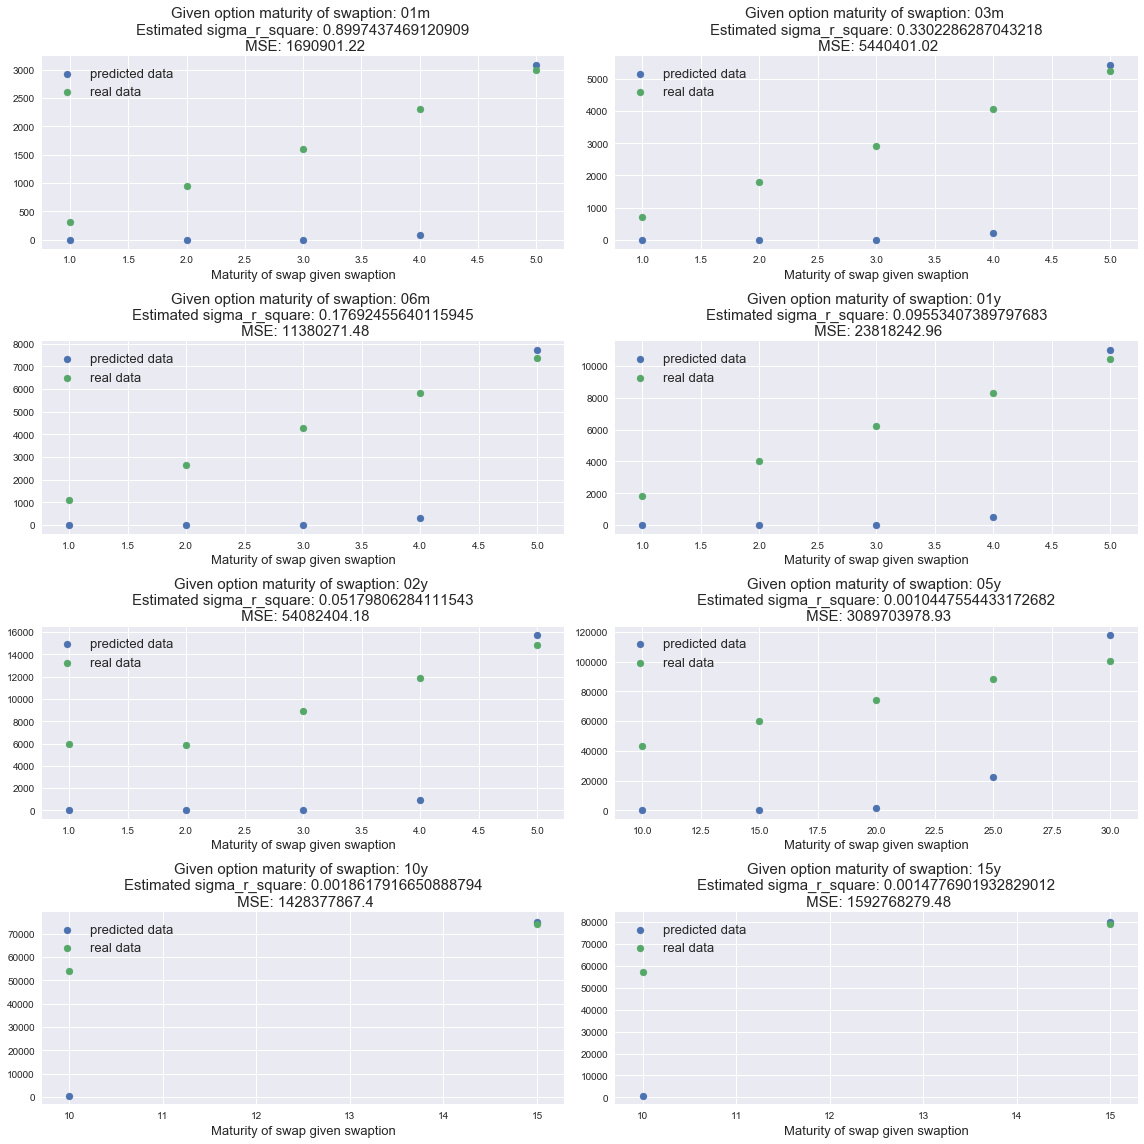

In [10]:
fig, axs = plt.subplots(
    nrows=4, ncols=2, figsize=(16, 16), facecolor='white'
)

axs = axs.ravel()

for i in range(len(data_dict.keys())):
    current_swaption_name = list(data_dict.keys())[i]
    
    popt = result[result.swaption_name == current_swaption_name]['popt'].values[0]
    MSE = result[result.swaption_name == current_swaption_name]['MSE'].values[0]
    MSE = round(MSE, 2)
    
    # 指定欲估計的合約資料
    target_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['target_price'],
        data_dict[current_swaption_name].keys()
    ))

    t_T_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['t_T'],
        data_dict[current_swaption_name].keys()
    ))

    Tn_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['Tn'],
        data_dict[current_swaption_name].keys()
    ))

    K_series = list(map(
        lambda x: data_dict[current_swaption_name][x]['K'],
        data_dict[current_swaption_name].keys()
    ))

    predict_series = wrapper_target_function(
        (t_T_series, Tn_series, K_series),
        result['popt'][i]
    )
    
    plt.sca(axs[i])
    plt.scatter(
        Tn_series, predict_series, label='predicted data'
    )

    plt.scatter(
        Tn_series, target_series, label='real data'
    )

    plt.legend(fontsize=13)
    plt.title(
        'Given option maturity of swaption: {} \n Estimated sigma_r_square: {} \n MSE: {}'.format(
            current_swaption_name, popt, MSE
        ),
        fontsize=15
    )
    plt.xlabel('Maturity of swap given swaption', fontsize=13)
    plt.tight_layout();

# 確認估計結果是否正確，看print出來的值單獨代回去公式是否一樣，同時也可以測看看更動估計出的sigma_r_square是否MSE會變大

In [11]:
data_dict.keys()

dict_keys(['01m', '03m', '06m', '01y', '02y', '05y', '10y', '15y'])

In [12]:
current_swaption_name = '01m'
given_sigma_r_square = 0.9206138220247724

target_series = list(map(
    lambda x: data_dict[current_swaption_name][x]['target_price'],
    data_dict[current_swaption_name].keys()
))

t_T_series = list(map(
    lambda x: data_dict[current_swaption_name][x]['t_T'],
    data_dict[current_swaption_name].keys()
))

Tn_series = list(map(
    lambda x: data_dict[current_swaption_name][x]['Tn'],
    data_dict[current_swaption_name].keys()
))

K_series = list(map(
    lambda x: data_dict[current_swaption_name][x]['K'],
    data_dict[current_swaption_name].keys()
))

predict_series = wrapper_target_function(
    (t_T_series, Tn_series, K_series),
    given_sigma_r_square
)

MSE = round(sum(
    map(lambda x: x**2, np.array(predict_series) - np.array(target_series))
) / len(target_series), 2)

print('MSE: {}'.format(MSE/1000000))

intital_parameters_collection:
[0.08333333 1.         0.01364652]
series_of_inner_target_function:
[2.04977475e-207 5.72048713e-049]
summation_of_inner_target_function:
5.720487133762776e-49
current_sigma_r_square:
0.9206138220247724

intital_parameters_collection:
[0.08333333 2.         0.01231497]
series_of_inner_target_function:
[1.15187382e-217 1.47721021e-051 1.71425038e-020 1.70453927e-009]
summation_of_inner_target_function:
1.7045392659487372e-09
current_sigma_r_square:
0.9206138220247724

intital_parameters_collection:
[0.08333333 3.         0.01184772]
series_of_inner_target_function:
[1.36964897e-221 1.50822456e-052 6.16892998e-021 9.56168685e-010
 1.68480519e-004 1.30650305e-001]
summation_of_inner_target_function:
0.13081878656961488
current_sigma_r_square:
0.9206138220247724

intital_parameters_collection:
[0.08333333 4.         0.01170424]
series_of_inner_target_function:
[7.81984967e-223 7.31999102e-053 4.46256272e-021 7.96136431e-010
 1.49783098e-004 1.20388528e-001 7.

# 觀察：
* 嘗試更動sigma_r_square的估計值觀觀察：
  1. 基本上更動時MSE都變大
  2. 但給定swaption_name為02y時，發現把值更改為0.03時，MSE下降許多

<br></br>

* 發現當k值代0.03時，MSE普遍會較小

<br></br>

* 發現預測值和實際值都在最後一個點會很靠近，有嘗試將最後一個點drop掉去fit，結果一樣會是drop掉後最右邊的值(原先右邊數來第二個)，其估計值和預測值最近